# Calculate Compound Years for CESM

This file grabs the warm season indeces and sees if this shows us anything


You need to run cesmTradIndeces.ipnyb first (which in turn requires calculateCesmMonthlyIndeces.ipnyb)

In [94]:
#For plots of a single experiment to demonstrate things, plot this one:

expToPlot = 'LME.008'

In [78]:
#import my functions
import utils._modelDefinitions as _model
import utils._indexDefinitions as _index
from utils.timePeriod import averageForTimePeriod


In [79]:
import xarray
import matplotlib.pyplot as plt
import numpy
import pandas

%matplotlib inline

In [92]:
# Here is the data
indecesDa = xarray.load_dataarray('results/cesmTradIndeces.nc')

indecesDa.experiment.values

array(['0850cntl.001', 'LME.002', 'LME.003', 'LME.008', 'LME.009', '001',
       '002', '003', '004', '005', '006', '007', '008', '009', '010',
       '011', '012', '013'], dtype=object)

# Define a criteria to determine events, and plot an example

So we are going to define events as follows:
- For SST indeces (aka Enso and Iod), this is 1 sigma above/below mean
- For PSL indeces (aka Sam) this is 0.5 sigma above/below mean

For now, using a 850-1850 climatology

In [82]:
# define some criteria that we want to use to identifiy it thats an event

# This should calculate stds for all experiments and all indeces
stdDa = indecesDa.std(dim='year')

criteriaDa = xarray.concat(
    (
        stdDa.sel(index=['nino34','dmi']),
        stdDa.sel(index='sam')/2
    ),
    'index'
)

CESM Model Run: LME.008


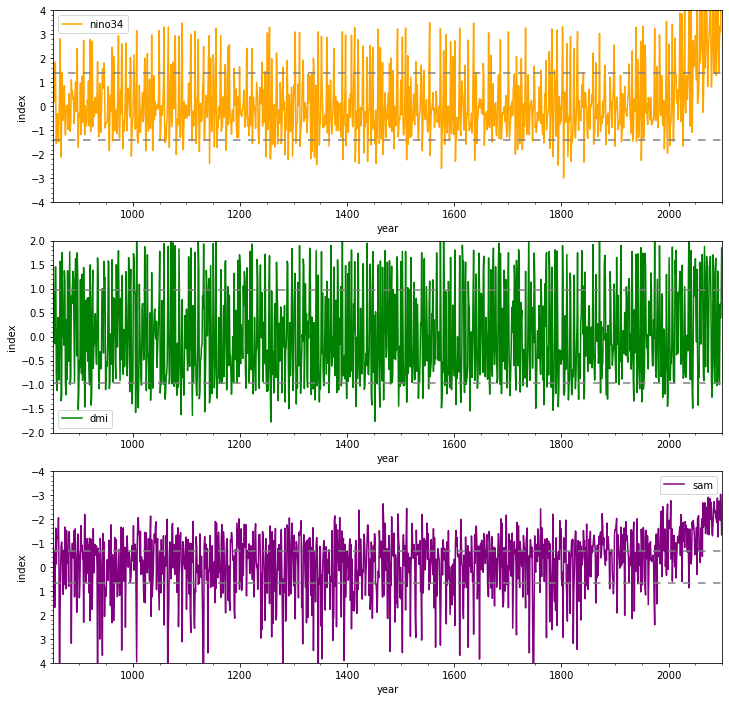

In [83]:
# plot indeces for an experiment, and add some lines for +- 1 sigma

indexToPlot = ['nino34', 'dmi', 'sam']
colors = ['orange', 'green', 'purple']
lims = [(-4,4), [-2,2], [4,-4]]

print('CESM Model Run: ' + expToPlot)

# first define somewhere to plot
fig = plt.figure(figsize=(12,12))

for i in range(3):
    
    fig.add_subplot(3,1,i+1)
    
    plotData=indecesDa.sel(experiment=expToPlot, index=indexToPlot[i]) 
    eventCrit=criteriaDa.sel(experiment=expToPlot, index=indexToPlot[i]).values
    
    #colors = numpy.where(plotData.values>eventCrit,'red','orange')

    # plot the actual data
    plt.plot(plotData.year, plotData.values, label=indexToPlot[i], color=colors[i])
    #plt.vlines(x=plotData.year, ymin=0, ymax=plotData.values, label=indexToPlot[i], color=colors[i],)
    
    # draw some horizontal lines for criteria
    plt.axhline(y=eventCrit, dashes=(5,5), color='grey')
    plt.axhline(y=-eventCrit, dashes=(5,5), color='grey')

    #Tidy up a bit
    plt.xlabel('year')
    plt.ylabel('index')
    plt.xlim(850,2100)
    plt.ylim(lims[i])
    plt.minorticks_on()
    plt.legend()


# Calculate the compounding years and plot an example

In [84]:
%run 'utils/compound.ipynb'
posCount, negCount = applyCriteria(indecesDa, criteriaDa)

(1700.0, 2100.0)

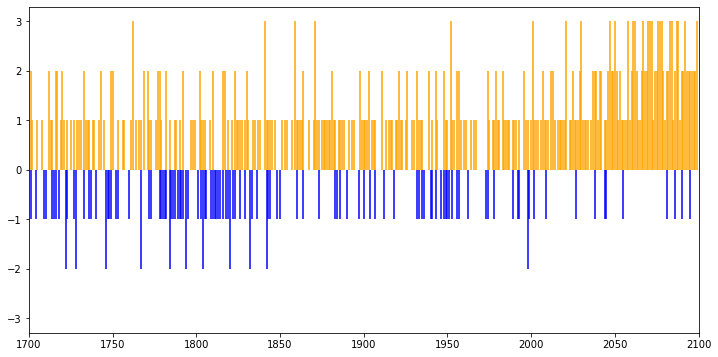

In [85]:
#plot the pos events in orange and the neg count in blue

fig = plt.figure(figsize=(12,6))
plt.vlines(
    x=negCount.year, 
    ymin=negCount.sel(experiment=expToPlot).values,
    ymax=0,
    colors='blue'
)

plt.vlines(
    x=posCount.year, 
    ymin=0,
    ymax=posCount.sel(experiment=expToPlot).values,
    colors='orange'
)
plt.xlim(1700,2100)

# Put the compounds into 30 year intervals

In [86]:
yearBins=numpy.arange(870,2130,30)

In [87]:
binnedPosCount=(posCount>1).groupby_bins('year', yearBins).sum()
binnedNegCount=-(negCount<-1).groupby_bins('year', yearBins).sum()

In [88]:
binnedPosCount.sel(experiment=expToPlot)

<xarray.DataArray (year_bins: 41)>
array([ 7.,  4.,  6.,  5.,  6.,  4.,  5.,  2.,  3.,  5.,  6.,  5.,  3.,
        3.,  5.,  5.,  3.,  5.,  6.,  6.,  6.,  4.,  4.,  3.,  3.,  5.,
        4.,  5.,  5.,  5.,  5.,  6.,  2.,  3.,  3.,  6.,  5.,  4.,  9.,
       19., 25.])
Coordinates:
  * year_bins   (year_bins) object (870, 900] (900, 930] ... (2070, 2100]
    experiment  <U7 'LME.008'

In [89]:
#stupidly complicated way to figure out the mid points of my bins?
x = pandas.IntervalIndex(binnedNegCount.year_bins.values).mid

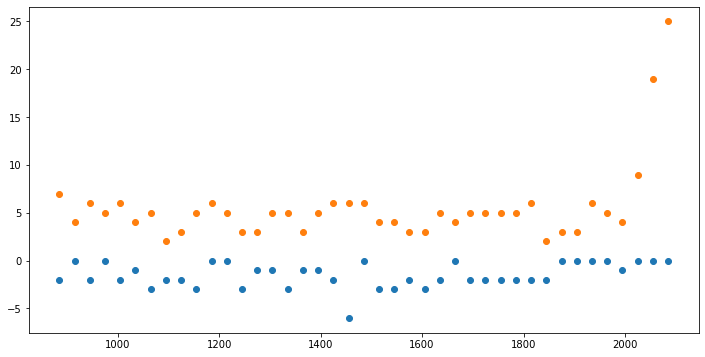

In [97]:
fig = plt.figure(figsize=(12,6))

plt.scatter(x, binnedNegCount.sel(experiment=expToPlot).values)
plt.scatter(x, binnedPosCount.sel(experiment=expToPlot).values)


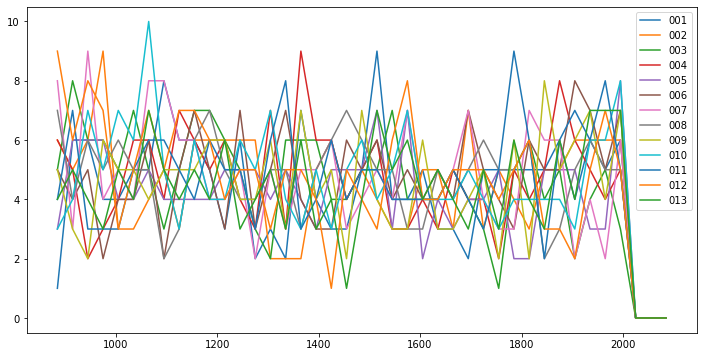

In [105]:
fig = plt.figure(figsize=(12,6))

for iExp in list(_model.cesmFullForcings):
    plt.plot(x, binnedPosCount.sel(experiment=iExp).values, label=iExp)
    
plt.legend()

In [110]:
std = binnedPosCount.std(dim='experiment')

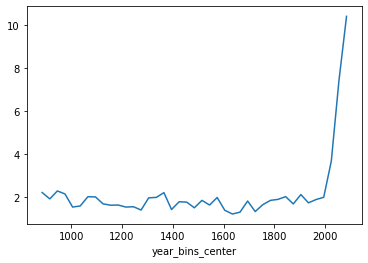

In [112]:
std.plot()